# Time-Series MIA Example 
Base of example. Use and build upon this notebook during development.

In [1]:
import os
import sys
import yaml
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import ECGDataset, preprocess_ECG_dataset, get_ECG_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import SimpleLSTM, create_trained_model_and_metadata

In [2]:
# Define constants
lookback = 100
horizon = 10
train_fraction = 0.6
epochs = 5

In [3]:
# Get data loaders
path = os.path.join(os.getcwd(), "data")
dataset = preprocess_ECG_dataset(path, lookback, horizon)
train_loader, test_loader = get_ECG_dataloaders(dataset, train_fraction)

In [4]:
# Train the LSTM model
input_size = 12 # input size will be the amount of variables in the Time-Series
model = SimpleLSTM(input_size, horizon)
train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs)

Training Progress: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


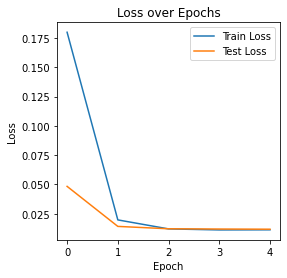

In [5]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [6]:
from ECG_handler import ECGInputHandler
from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(ECGInputHandler, config_path)

# Run the audit 
leakpro.run_audit()

2025-02-11 21:09:42,077 INFO     Target model blueprint created from SimpleLSTM in ./utils/model_preparation.py.
2025-02-11 21:09:42,079 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-02-11 21:09:42,086 INFO     Loaded target model from ./target
2025-02-11 21:09:42,204 INFO     Loaded population dataset from ./data/ECG_E00001.pkl
2025-02-11 21:09:42,206 INFO     Loaded population dataset from ./data/ECG_E00001.pkl


{'audit': {'random_seed': 42, 'attack_list': {}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/model_preparation.py', 'model_class': 'SimpleLSTM', 'target_folder': './target', 'data_path': './data/ECG_E00001.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-02-11 21:09:42,771 INFO     MIA attack factory loaded.
2025-02-11 21:09:42,772 INFO     Auditing completed
